# NER Dataset Analysis

## 1. Import dependencies

In [1]:
# Standard library imports
import json
import sys
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, List, Tuple

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import custom data loader
from src.data import load_processed_data

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook', font_scale=1.1)
sns.set_palette('deep')

# Figure defaults
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


Python version: 3.12.12
NumPy version: 1.26.4
Pandas version: 2.3.3
Matplotlib version: 3.10.8
Seaborn version: 0.13.2


## 2. Data Loading and Preprocessing

In [2]:
# Define data paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "vlps_2018_ner" / "processed"
OUTPUT_DIR = PROJECT_ROOT / "docs"

# Ensure output directory exists
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Load all splits using src.data loader
data_splits = load_processed_data()
train_data = data_splits['train']
dev_data = data_splits['dev']
test_data = data_splits['test']
all_data = train_data + dev_data + test_data

# Basic dataset information
print("Dataset Split Distribution")
print("=" * 50)
print(f"Training set:   {len(train_data):5d} records ({len(train_data)/len(all_data)*100:5.2f}%)")
print(f"Development set:{len(dev_data):5d} records ({len(dev_data)/len(all_data)*100:5.2f}%)")
print(f"Test set:       {len(test_data):5d} records ({len(test_data)/len(all_data)*100:5.2f}%)")
print(f"{'='*50}")
print(f"Total:          {len(all_data):5d} records")

Dataset Split Distribution
Training set:     781 records (60.92%)
Development set:  260 records (20.28%)
Test set:         241 records (18.80%)
Total:           1282 records


In [4]:
# Display sample record structure
sample_record = train_data[0]

print("Sample Record Structure")
print("=" * 80)
print(f"ID: {sample_record['id']}")
print(f"Topic: {sample_record['topic']}")
print(f"\nTitle:")
print(f"{sample_record['title'][:100]}...")
print(f"\nText (first 200 characters):")
print(f"{sample_record['text'][:200]}...")
print(f"\nGround Truth Entities:")
for entity_type, entities in sample_record['ground_truth'].items():
    print(f"  {entity_type}: {len(entities)} entities")
    if entities:
        print(f"    Example: {entities[0]}")

Sample Record Structure
ID: 23351225
Topic: Doi song

Title:
Chuyện đau khi tiêm...

Text (first 200 characters):
Nỗi đau của người bệnh khi bị tiêm, kéo dài vài giây, vài phút, cùng lắm có thể đến vài ngày. Nhưng nỗi đau của người làm y tế khi đọc, khi nghe những nhận định đổ lỗi, gắn mác phong bì thì còn kéo dà...

Ground Truth Entities:
  person: 0 entities
  organizations: 1 entities
    Example: Tổ chức y tế Thế giới
  address: 0 entities


## 3. Descriptive Statistics

In [5]:
def compute_split_statistics(data: List[Dict], split_name: str) -> Dict:
    """
    Compute comprehensive statistics for a dataset split.
    
    Parameters:
    -----------
    data : List[Dict]
        Dataset records
    split_name : str
        Name of the split
    
    Returns:
    --------
    Dict
        Dictionary containing computed statistics
    """
    text_lengths = []
    title_lengths = []
    word_counts = []
    entities_per_doc = []
    
    person_count = 0
    org_count = 0
    addr_count = 0
    
    for record in data:
        # Text metrics
        text_lengths.append(len(record['text']))
        title_lengths.append(len(record['title']))
        word_counts.append(len(record['text'].split()))
        
        # Entity counts
        gt = record['ground_truth']
        n_persons = len(gt['person'])
        n_orgs = len(gt['organizations'])
        n_addrs = len(gt['address'])
        
        person_count += n_persons
        org_count += n_orgs
        addr_count += n_addrs
        entities_per_doc.append(n_persons + n_orgs + n_addrs)
    
    return {
        'split': split_name,
        'n_documents': len(data),
        'n_entities_total': person_count + org_count + addr_count,
        'n_persons': person_count,
        'n_organizations': org_count,
        'n_addresses': addr_count,
        'entities_per_doc_mean': np.mean(entities_per_doc),
        'entities_per_doc_std': np.std(entities_per_doc),
        'entities_per_doc_median': np.median(entities_per_doc),
        'text_length_mean': np.mean(text_lengths),
        'text_length_std': np.std(text_lengths),
        'text_length_median': np.median(text_lengths),
        'text_length_p25': np.percentile(text_lengths, 25),
        'text_length_p75': np.percentile(text_lengths, 75),
        'text_length_p95': np.percentile(text_lengths, 95),
        'word_count_mean': np.mean(word_counts),
        'word_count_std': np.std(word_counts),
        'title_length_mean': np.mean(title_lengths),
    }

# Compute statistics for all splits
stats_train = compute_split_statistics(train_data, 'Train')
stats_dev = compute_split_statistics(dev_data, 'Dev')
stats_test = compute_split_statistics(test_data, 'Test')
stats_all = compute_split_statistics(all_data, 'Overall')

# Create summary DataFrame
stats_df = pd.DataFrame([stats_train, stats_dev, stats_test, stats_all])
stats_df = stats_df.set_index('split')

print("\nDataset Statistics Summary")
print("=" * 100)
display(stats_df[['n_documents', 'n_entities_total', 'n_persons', 
                   'n_organizations', 'n_addresses', 'entities_per_doc_mean']])


Dataset Statistics Summary


,n_documents,n_entities_total,n_persons,n_organizations,n_addresses,entities_per_doc_mean
split,,,,,,
Train,781,8992,3308,1672,4012,11.51
Dev,260,3032,1067,584,1381,11.66
Test,241,3869,1829,737,1303,16.05
Overall,1282,15893,6204,2993,6696,12.40


### 3.1 Text Length Distribution

In [6]:
# Extract text metrics
text_lengths = np.array([len(r['text']) for r in all_data])
word_counts = np.array([len(r['text'].split()) for r in all_data])

# Compute descriptive statistics
text_stats = {
    'Metric': ['Mean', 'Std Dev', 'Median', 'IQR', 'Min', 'Max', '95th Percentile'],
    'Characters': [
        text_lengths.mean(),
        text_lengths.std(),
        np.median(text_lengths),
        np.percentile(text_lengths, 75) - np.percentile(text_lengths, 25),
        text_lengths.min(),
        text_lengths.max(),
        np.percentile(text_lengths, 95)
    ],
    'Words': [
        word_counts.mean(),
        word_counts.std(),
        np.median(word_counts),
        np.percentile(word_counts, 75) - np.percentile(word_counts, 25),
        word_counts.min(),
        word_counts.max(),
        np.percentile(word_counts, 95)
    ]
}

text_stats_df = pd.DataFrame(text_stats)
print("\nText Length Statistics")
print("=" * 60)
display(text_stats_df)


Text Length Statistics


,Metric,Characters,Words
0,Mean,2864.41,627.91
1,Std Dev,1937.59,425.87
2,Median,2468.00,541.00
3,IQR,2248.00,487.25
4,Min,36.00,8.00
5,Max,13848.00,3117.00
6,95th Percentile,6615.10,1443.00


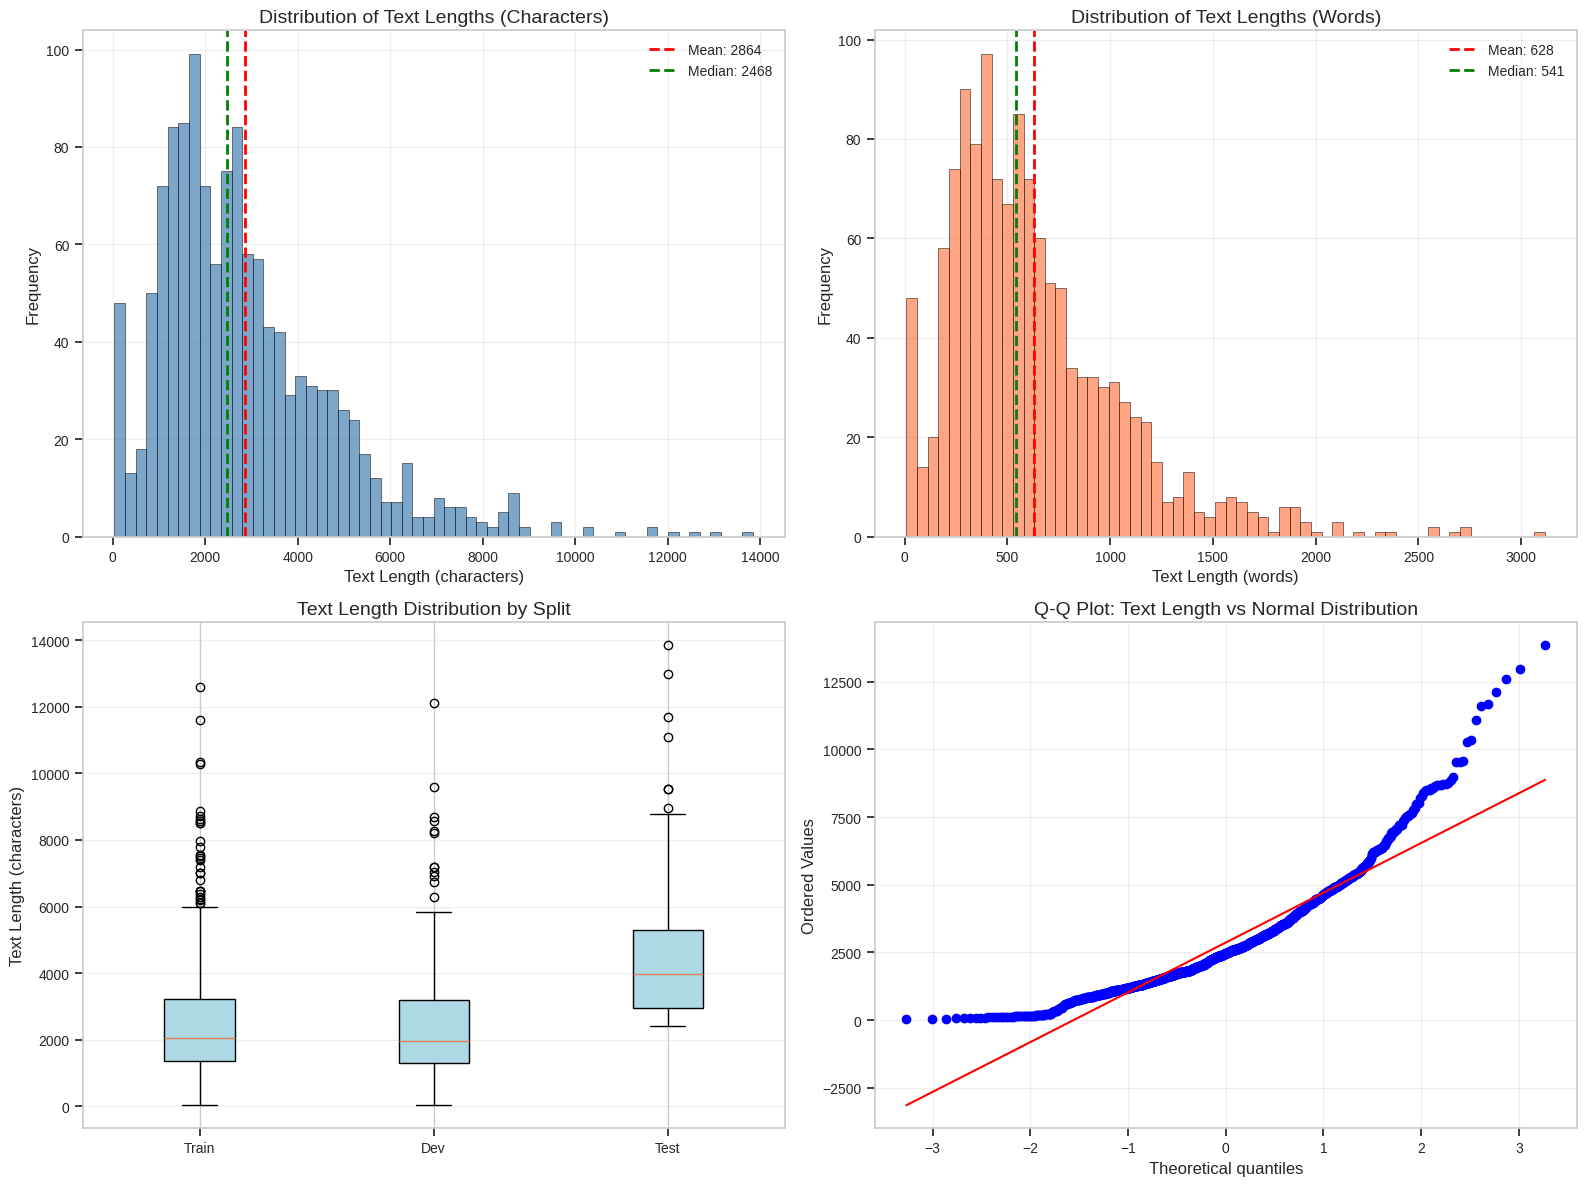

In [7]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character count distribution
axes[0, 0].hist(text_lengths, bins=60, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0, 0].axvline(text_lengths.mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {text_lengths.mean():.0f}')
axes[0, 0].axvline(np.median(text_lengths), color='green', linestyle='--', linewidth=2,
                    label=f'Median: {np.median(text_lengths):.0f}')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Text Lengths (Characters)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Word count distribution
axes[0, 1].hist(word_counts, bins=60, color='coral', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0, 1].axvline(word_counts.mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Mean: {word_counts.mean():.0f}')
axes[0, 1].axvline(np.median(word_counts), color='green', linestyle='--', linewidth=2,
                    label=f'Median: {np.median(word_counts):.0f}')
axes[0, 1].set_xlabel('Text Length (words)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Text Lengths (Words)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plot for text lengths by split
split_data = [
    [len(r['text']) for r in train_data],
    [len(r['text']) for r in dev_data],
    [len(r['text']) for r in test_data]
]
bp = axes[1, 0].boxplot(split_data, labels=['Train', 'Dev', 'Test'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1, 0].set_ylabel('Text Length (characters)')
axes[1, 0].set_title('Text Length Distribution by Split')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Q-Q plot for normality assessment
stats.probplot(text_lengths, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Text Length vs Normal Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'text_length_distribution.png')
plt.show()


## 4. Entity Distribution Analysis

In [8]:
# Collect all entities
all_persons = []
all_orgs = []
all_addrs = []

entities_per_doc = []

for record in all_data:
    gt = record['ground_truth']
    all_persons.extend(gt['person'])
    all_orgs.extend(gt['organizations'])
    all_addrs.extend(gt['address'])
    
    total = len(gt['person']) + len(gt['organizations']) + len(gt['address'])
    entities_per_doc.append(total)

# Compute entity statistics
entity_stats = pd.DataFrame({
    'Entity Type': ['Person', 'Organization', 'Address', 'Total'],
    'Total Count': [
        len(all_persons),
        len(all_orgs),
        len(all_addrs),
        len(all_persons) + len(all_orgs) + len(all_addrs)
    ],
    'Unique Count': [
        len(set(all_persons)),
        len(set(all_orgs)),
        len(set(all_addrs)),
        len(set(all_persons)) + len(set(all_orgs)) + len(set(all_addrs))
    ]
})

entity_stats['Uniqueness Ratio'] = entity_stats['Unique Count'] / entity_stats['Total Count']
entity_stats['Percentage'] = (entity_stats['Total Count'] / entity_stats.loc[3, 'Total Count']) * 100

print("\nEntity Type Statistics")
print("=" * 80)
display(entity_stats)


Entity Type Statistics


,Entity Type,Total Count,Unique Count,Uniqueness Ratio,Percentage
0,Person,6204,4486,0.72,39.04
1,Organization,2993,1815,0.61,18.83
2,Address,6696,2834,0.42,42.13
3,Total,15893,9135,0.57,100.00


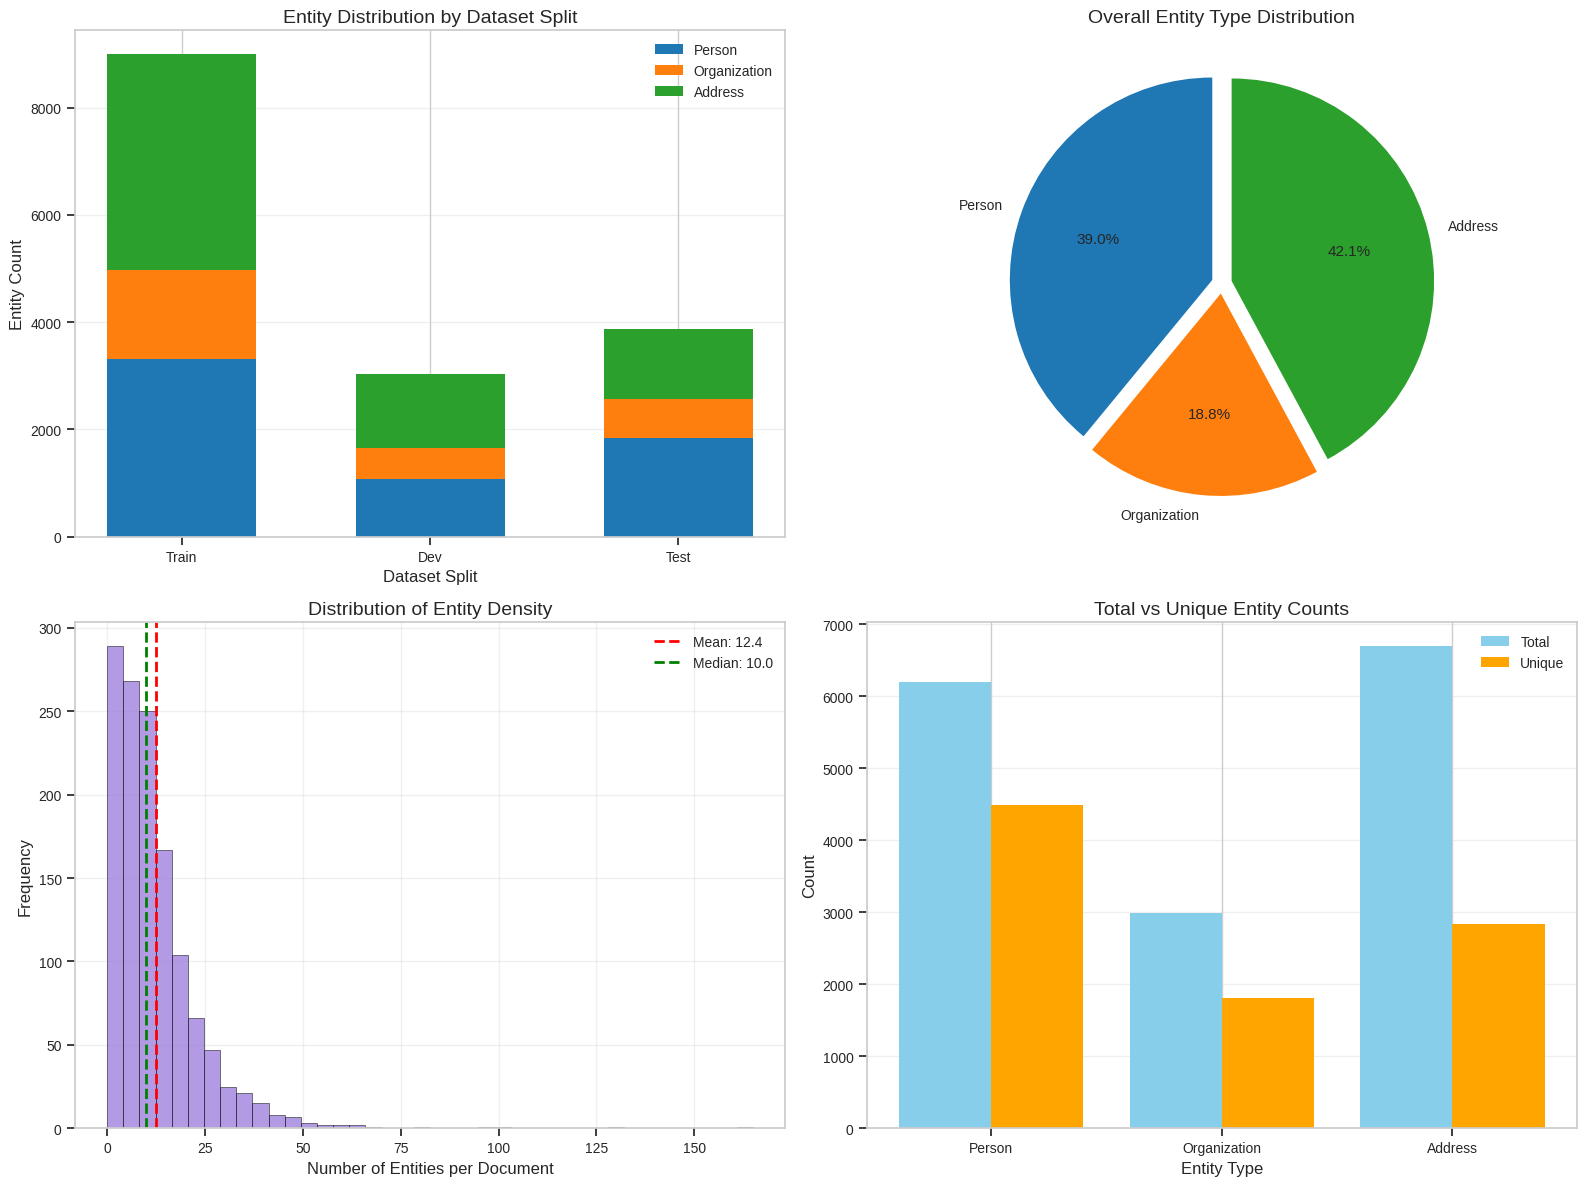

In [9]:
# Visualize entity distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Entity type distribution across splits (stacked bar)
splits = ['Train', 'Dev', 'Test']
person_counts = [
    sum(len(r['ground_truth']['person']) for r in train_data),
    sum(len(r['ground_truth']['person']) for r in dev_data),
    sum(len(r['ground_truth']['person']) for r in test_data)
]
org_counts = [
    sum(len(r['ground_truth']['organizations']) for r in train_data),
    sum(len(r['ground_truth']['organizations']) for r in dev_data),
    sum(len(r['ground_truth']['organizations']) for r in test_data)
]
addr_counts = [
    sum(len(r['ground_truth']['address']) for r in train_data),
    sum(len(r['ground_truth']['address']) for r in dev_data),
    sum(len(r['ground_truth']['address']) for r in test_data)
]

x = np.arange(len(splits))
width = 0.6

axes[0, 0].bar(x, person_counts, width, label='Person', color='#1f77b4')
axes[0, 0].bar(x, org_counts, width, bottom=person_counts, label='Organization', color='#ff7f0e')
axes[0, 0].bar(x, addr_counts, width, 
               bottom=np.array(person_counts) + np.array(org_counts),
               label='Address', color='#2ca02c')
axes[0, 0].set_xlabel('Dataset Split')
axes[0, 0].set_ylabel('Entity Count')
axes[0, 0].set_title('Entity Distribution by Dataset Split')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(splits)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Overall entity type proportions (pie chart)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
explode = (0.05, 0.05, 0.05)
axes[0, 1].pie([len(all_persons), len(all_orgs), len(all_addrs)],
               labels=['Person', 'Organization', 'Address'],
               autopct='%1.1f%%',
               colors=colors,
               explode=explode,
               startangle=90)
axes[0, 1].set_title('Overall Entity Type Distribution')

# Entities per document distribution
axes[1, 0].hist(entities_per_doc, bins=40, color='mediumpurple', alpha=0.7, 
                edgecolor='black', linewidth=0.5)
axes[1, 0].axvline(np.mean(entities_per_doc), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(entities_per_doc):.1f}')
axes[1, 0].axvline(np.median(entities_per_doc), color='green', linestyle='--',
                    linewidth=2, label=f'Median: {np.median(entities_per_doc):.1f}')
axes[1, 0].set_xlabel('Number of Entities per Document')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Entity Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Uniqueness comparison
entity_types = ['Person', 'Organization', 'Address']
total_counts = [len(all_persons), len(all_orgs), len(all_addrs)]
unique_counts = [len(set(all_persons)), len(set(all_orgs)), len(set(all_addrs))]

x_pos = np.arange(len(entity_types))
axes[1, 1].bar(x_pos - 0.2, total_counts, 0.4, label='Total', color='skyblue')
axes[1, 1].bar(x_pos + 0.2, unique_counts, 0.4, label='Unique', color='orange')
axes[1, 1].set_xlabel('Entity Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Total vs Unique Entity Counts')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(entity_types)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'entity_distribution.png')
plt.show()



## 5. Topic Analysis

In [10]:
# Analyze topic distribution
topics = Counter([r['topic'] for r in all_data])
topic_df = pd.DataFrame([
    {'Topic': topic, 'Count': count, 'Percentage': (count / len(all_data)) * 100}
    for topic, count in topics.most_common()
])

print(f"\nTopic Distribution (Total: {len(topics)} unique topics)")
print("=" * 70)
display(topic_df.head(15))

# Statistical summary
print(f"\nTopic Distribution Statistics:")
print(f"Mean documents per topic: {topic_df['Count'].mean():.2f}")
print(f"Std deviation: {topic_df['Count'].std():.2f}")
print(f"Median documents per topic: {topic_df['Count'].median():.2f}")
print(f"Coefficient of variation: {(topic_df['Count'].std() / topic_df['Count'].mean()):.2f}")


Topic Distribution (Total: 27 unique topics)


,Topic,Count,Percentage
0,Van hoa,129,10.06
1,Xa hoi,124,9.67
2,Kinh te,120,9.36
3,Giai tri,118,9.20
4,Phap luat,115,8.97
5,The thao,110,8.58
6,Giao duc,109,8.50
7,The gioi,109,8.50
8,KH - CN,100,7.80
9,Doi song,93,7.25



Topic Distribution Statistics:
Mean documents per topic: 47.48
Std deviation: 51.63
Median documents per topic: 14.00
Coefficient of variation: 1.09


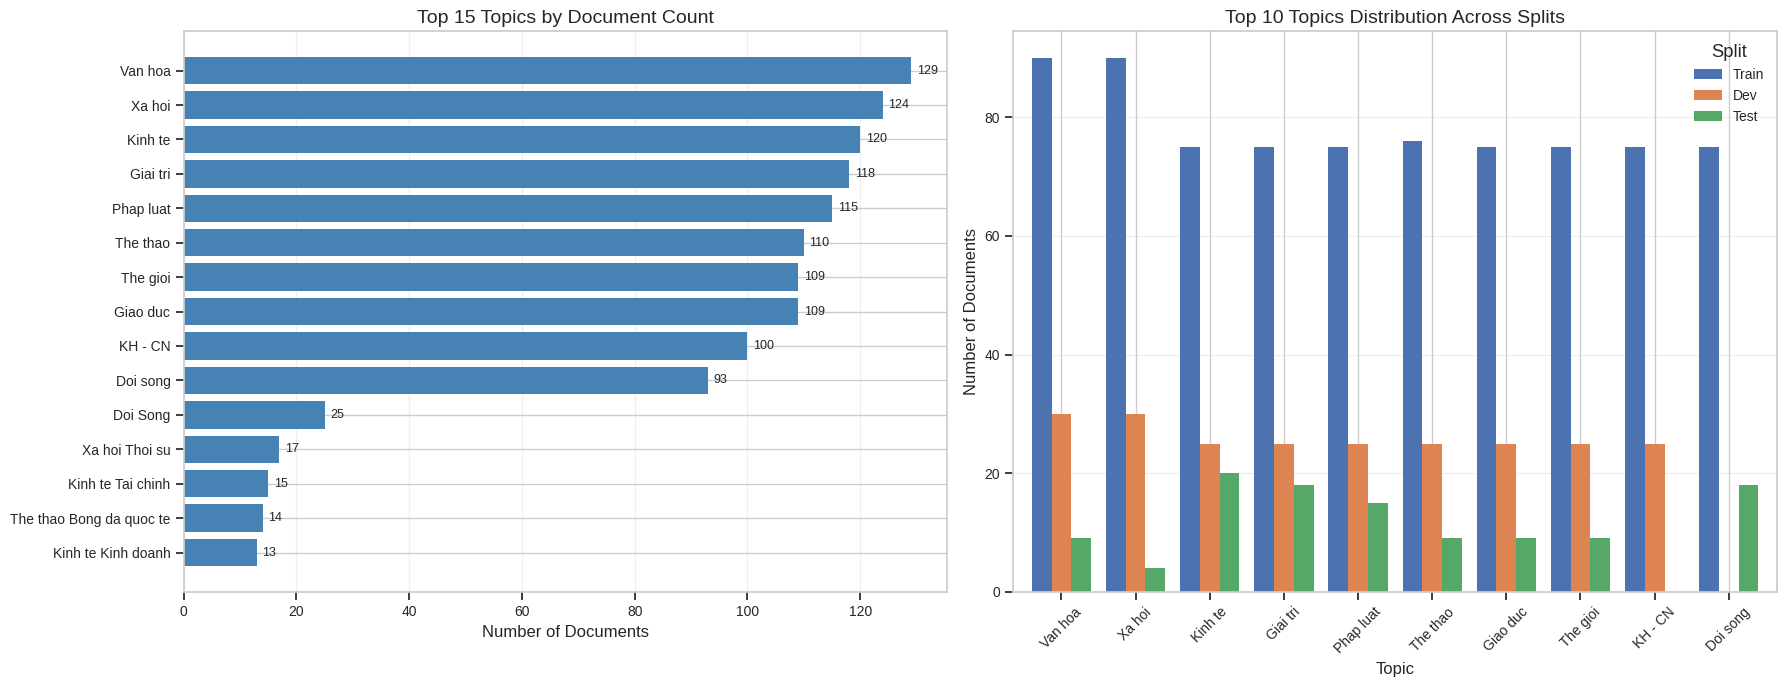

In [11]:
# Visualize topic distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Top topics horizontal bar chart
top_topics = topic_df.head(15).sort_values('Count')
axes[0].barh(range(len(top_topics)), top_topics['Count'], color='steelblue')
axes[0].set_yticks(range(len(top_topics)))
axes[0].set_yticklabels(top_topics['Topic'])
axes[0].set_xlabel('Number of Documents')
axes[0].set_title('Top 15 Topics by Document Count')
axes[0].grid(True, alpha=0.3, axis='x')

# Add count labels
for i, (idx, row) in enumerate(top_topics.iterrows()):
    axes[0].text(row['Count'] + 1, i, str(int(row['Count'])), 
                 va='center', fontsize=9)

# Topic distribution across splits
topic_split_data = []
for topic in topic_df.head(10)['Topic']:
    topic_split_data.append({
        'Topic': topic,
        'Train': sum(1 for r in train_data if r['topic'] == topic),
        'Dev': sum(1 for r in dev_data if r['topic'] == topic),
        'Test': sum(1 for r in test_data if r['topic'] == topic)
    })

topic_split_df = pd.DataFrame(topic_split_data)
topic_split_df.set_index('Topic')[['Train', 'Dev', 'Test']].plot(
    kind='bar', ax=axes[1], width=0.8
)
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Number of Documents')
axes[1].set_title('Top 10 Topics Distribution Across Splits')
axes[1].legend(title='Split')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'topic_distribution.png')
plt.show()


## 6. Entity Frequency Analysis

In [12]:
# Count entity occurrences
person_counter = Counter(all_persons)
org_counter = Counter(all_orgs)
addr_counter = Counter(all_addrs)

# Get top entities
TOP_N = 20

top_persons_df = pd.DataFrame(
    person_counter.most_common(TOP_N),
    columns=['Entity', 'Frequency']
)
top_persons_df['Type'] = 'Person'

top_orgs_df = pd.DataFrame(
    org_counter.most_common(TOP_N),
    columns=['Entity', 'Frequency']
)
top_orgs_df['Type'] = 'Organization'

top_addrs_df = pd.DataFrame(
    addr_counter.most_common(TOP_N),
    columns=['Entity', 'Frequency']
)
top_addrs_df['Type'] = 'Address'

print(f"\nTop {TOP_N} Most Frequent Entities by Type")
print("=" * 80)

print("\nPersons:")
display(top_persons_df.head(10))

print("\nOrganizations:")
display(top_orgs_df.head(10))

print("\nAddresses:")
display(top_addrs_df.head(10))


Top 20 Most Frequent Entities by Type

Persons:


,Entity,Frequency,Type
0,Donald Trump,32,Person
1,Trump,20,Person
2,Hà Văn Thắm,16,Person
3,Vũ Hồng Việt,15,Person
4,Sơn,14,Person
5,Nguyên Hoàng,14,Person
6,Thảo,13,Person
7,Lâm,12,Person
8,Nguyễn Thị Nghĩa,12,Person
9,Messi,12,Person



Organizations:


,Entity,Frequency,Type
0,TTXVN,34,Organization
1,Reuters,27,Organization
2,Vietnam+,27,Organization
3,AFP,26,Organization
4,Apple,24,Organization
5,Bộ Chính trị,18,Organization
6,Hồi giáo,18,Organization
7,Bộ Công Thương,17,Organization
8,VOV,16,Organization
9,Chelsea,16,Organization



Addresses:


,Entity,Frequency,Type
0,Việt Nam,328,Address
1,Mỹ,177,Address
2,Hà Nội,174,Address
3,Trung Quốc,112,Address
4,TP.HCM,75,Address
5,Anh,68,Address
6,Nga,68,Address
7,Nhật Bản,57,Address
8,Hàn Quốc,56,Address
9,châu Âu,51,Address


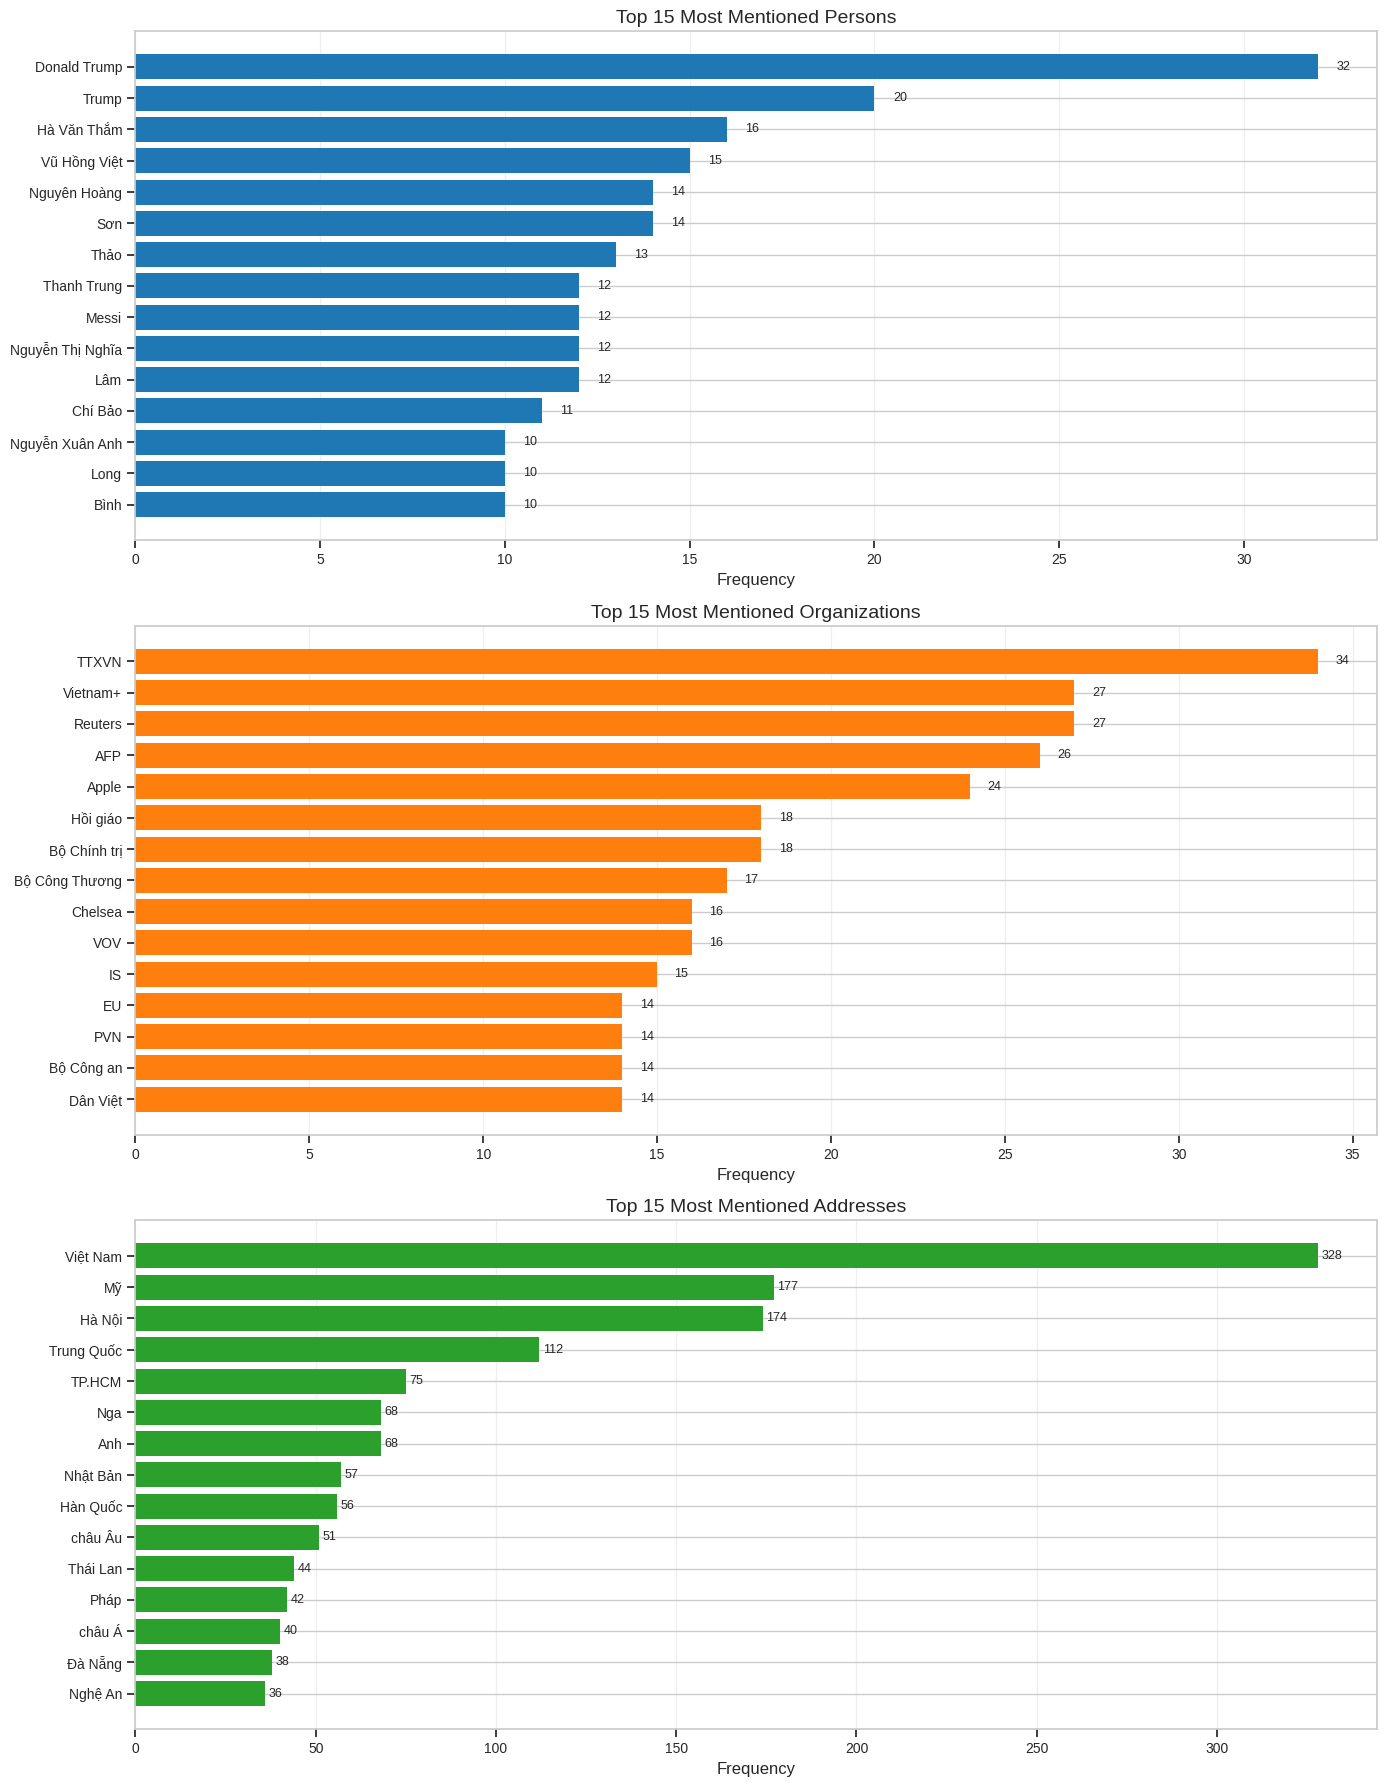

In [13]:
# Visualize top entities
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Top persons
top_persons = top_persons_df.head(15).sort_values('Frequency')
axes[0].barh(range(len(top_persons)), top_persons['Frequency'], color='#1f77b4')
axes[0].set_yticks(range(len(top_persons)))
axes[0].set_yticklabels(top_persons['Entity'])
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Most Mentioned Persons')
axes[0].grid(True, alpha=0.3, axis='x')
for i, (idx, row) in enumerate(top_persons.iterrows()):
    axes[0].text(row['Frequency'] + 0.5, i, str(int(row['Frequency'])), 
                 va='center', fontsize=9)

# Top organizations
top_orgs = top_orgs_df.head(15).sort_values('Frequency')
axes[1].barh(range(len(top_orgs)), top_orgs['Frequency'], color='#ff7f0e')
axes[1].set_yticks(range(len(top_orgs)))
axes[1].set_yticklabels(top_orgs['Entity'])
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Most Mentioned Organizations')
axes[1].grid(True, alpha=0.3, axis='x')
for i, (idx, row) in enumerate(top_orgs.iterrows()):
    axes[1].text(row['Frequency'] + 0.5, i, str(int(row['Frequency'])), 
                 va='center', fontsize=9)

# Top addresses
top_addrs = top_addrs_df.head(15).sort_values('Frequency')
axes[2].barh(range(len(top_addrs)), top_addrs['Frequency'], color='#2ca02c')
axes[2].set_yticks(range(len(top_addrs)))
axes[2].set_yticklabels(top_addrs['Entity'])
axes[2].set_xlabel('Frequency')
axes[2].set_title('Top 15 Most Mentioned Addresses')
axes[2].grid(True, alpha=0.3, axis='x')
for i, (idx, row) in enumerate(top_addrs.iterrows()):
    axes[2].text(row['Frequency'] + 1, i, str(int(row['Frequency'])), 
                 va='center', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'top_entities.png')
plt.show()


## 7. Entity Co-occurrence Analysis

In [14]:
# Analyze entity co-occurrence patterns
cooccurrence = defaultdict(int)

for record in all_data:
    gt = record['ground_truth']
    has_person = len(gt['person']) > 0
    has_org = len(gt['organizations']) > 0
    has_addr = len(gt['address']) > 0
    
    if has_person and has_org and has_addr:
        cooccurrence['All Three'] += 1
    elif has_person and has_org:
        cooccurrence['Person + Organization'] += 1
    elif has_person and has_addr:
        cooccurrence['Person + Address'] += 1
    elif has_org and has_addr:
        cooccurrence['Organization + Address'] += 1
    elif has_person:
        cooccurrence['Person Only'] += 1
    elif has_org:
        cooccurrence['Organization Only'] += 1
    elif has_addr:
        cooccurrence['Address Only'] += 1
    else:
        cooccurrence['No Entities'] += 1

# Create DataFrame
cooccurrence_df = pd.DataFrame([
    {'Pattern': k, 'Count': v, 'Percentage': (v / len(all_data)) * 100}
    for k, v in cooccurrence.items()
]).sort_values('Count', ascending=False)

print("\nEntity Co-occurrence Patterns")
print("=" * 70)
display(cooccurrence_df)


Entity Co-occurrence Patterns


,Pattern,Count,Percentage
2,All Three,676,52.73
6,Person + Address,271,21.14
5,Organization + Address,77,6.01
1,Person + Organization,62,4.84
3,Person Only,61,4.76
7,Address Only,53,4.13
4,No Entities,52,4.06
0,Organization Only,30,2.34


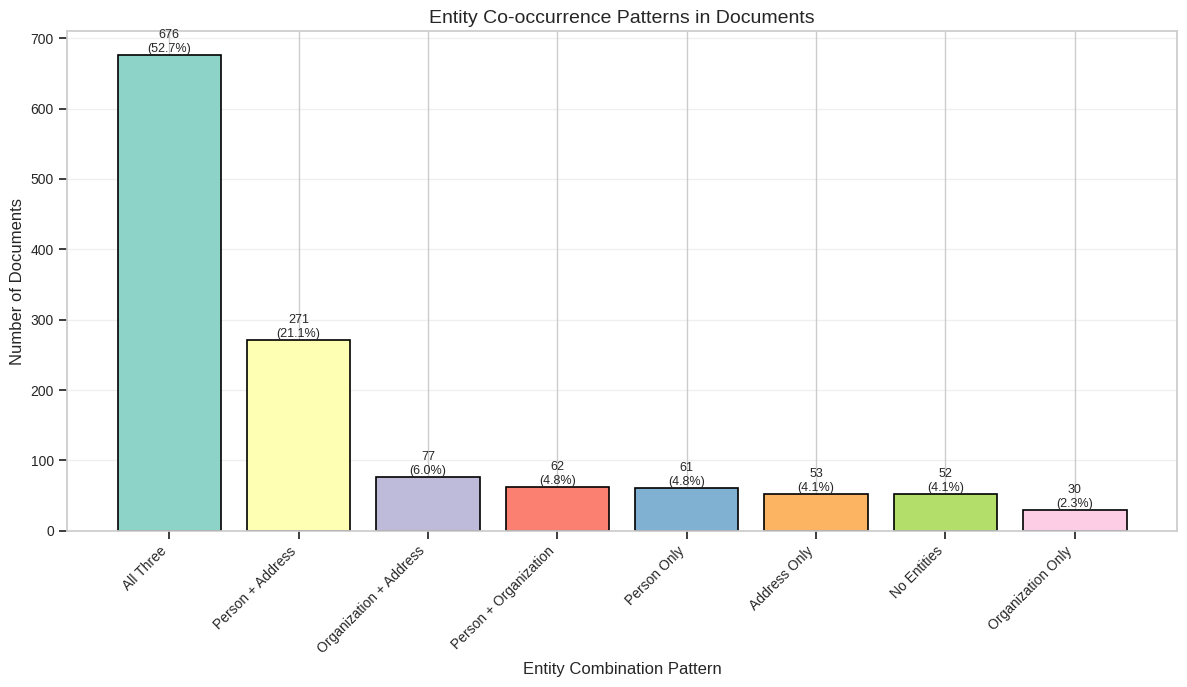

In [15]:
# Visualize co-occurrence patterns
fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.Set3(range(len(cooccurrence_df)))
bars = ax.bar(range(len(cooccurrence_df)), cooccurrence_df['Count'], 
              color=colors, edgecolor='black', linewidth=1.2)
ax.set_xticks(range(len(cooccurrence_df)))
ax.set_xticklabels(cooccurrence_df['Pattern'], rotation=45, ha='right')
ax.set_xlabel('Entity Combination Pattern')
ax.set_ylabel('Number of Documents')
ax.set_title('Entity Co-occurrence Patterns in Documents')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(cooccurrence_df.iterrows()):
    height = bars[i].get_height()
    ax.text(bars[i].get_x() + bars[i].get_width()/2., height,
            f"{int(row['Count'])}\n({row['Percentage']:.1f}%)",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cooccurrence_patterns.png')
plt.show()
